# Sistemas Inteligentes

## Exercício Computacional 5 - Otimização

#### 1.2 Explicação do Problema

Para este EC escolhemos um dataset de regressão "load_diabetes", que também foi usado em outro laboratório, e utilizando as ferramentas conhecidas queremos minimizar a função para conhecer os limites de otimização deste dataset.

### 2. Técnica

#### 2.1 Identificação da Técnica

Algoritmos Genéticos como exemplificado no lab, com as seguintes alterações:

Indivíduos são formados  uma lista de coeficientes de um polinômio, com valores float

Por consequência, funções de geração, mutação e torneio são ajustadas de acordo

Função de avaliação é o Mean Squared Error



#### 2.2 Explicação da Técnica

Como nosso objetivo era de exemplificar um problema otimização, escolhemos um dataset de regressão, especificamente o "load_diabetes", para a base de nosso desenvolvimento usamos um exemplo de um artigo que usa polinômios para fazer essa regressão.
Antes de regredir nossa função, foi usada a ferramenta PCA para compressão de dados, neste caso reduzimos o dataset para apenas uma dimensionalidade (X e Y), tendo o X apenas uma coluna.
Após a preparação deste dataset, aplicamos a função para realizar os testes de otimização deste Dataset.

## 3. Desenvolvimento Polinômios

A base para o desenvolvimento foi o seguinte <a href="https://towardsdatascience.com/intro-to-evolutionary-computation-using-deap-618ca974b8cb">Artigo Introdutório ao DEAP</a>, que realiza a modelagem de um problema de regressão utilizando polinômios.

### 3.1 Inicialização e dataset Diabetes

In [9]:
# Instalação do Deap e importação das bibliotecas
#!pip install deap

import array
from numpy import random

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

# Parâmetro Número de coeficientes no Polinômio
IND_SIZE = 5

In [10]:
# Carregando Dataset Diabetes
from sklearn.datasets import load_diabetes

X_full, Y = load_diabetes(return_X_y=True)

# Redução de dimensionalidade para uma dimensão Aplicando PCA
from sklearn.decomposition import PCA
X = PCA(n_components=1).fit_transform(X_full)
X = X[:,0].reshape(-1)

# Alterando formato do dataset para compatibilidade com o código
data = list(zip(X, Y))

# Ordenando dataset 
data = sorted(data, key=lambda tup: tup[0])

print(data[:10])
print(X.shape)
print(Y.shape)

[(-0.21466104597519378, 143.0), (-0.20513847280352315, 37.0), (-0.19721963028166126, 152.0), (-0.19220794435185848, 85.0), (-0.18915479410800604, 99.0), (-0.1886602796367919, 97.0), (-0.18603771275152337, 72.0), (-0.18482853739742686, 137.0), (-0.183419417624975, 101.0), (-0.17899936363801533, 48.0)]
(442,)
(442,)


### 3.2 Criação de Tipos, Toolbox, Função de Avaliação e Operadores Genéticos

In [11]:
# Definindo tipos

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)
creator.create("Strategy", array.array, typecode="d")

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [12]:
# Definindo funções para gerar indivíduos novos 

def generateES(ind_cls, strg_cls, size):
    ind = ind_cls(random.normal() for _ in range(size))
    ind.strategy = strg_cls(random.normal() for _ in range(size))
    return ind

toolbox = base.Toolbox()

# generation functions
toolbox.register("individual", generateES, creator.Individual, creator.Strategy, IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [13]:
# Definindo funções evolucionárias

toolbox.register("mate", tools.cxESBlend, alpha=0.1)
toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=3)

In [14]:
# Definindo funções de avaliação

# Na predição, o indivíduo é lido como um polinômio
def pred(ind, x):
    y_ = 0.0
    for i in range(1,IND_SIZE):
        y_ += ind[i-1]*x**i
    y_ += ind[IND_SIZE-1]
    return y_

# A função de avaliação é o erro médio quadrático
def evalFitness(ind, data):
    mse = 0.0
    for x, y in data:
        y_ = pred(ind, x)
        mse += (y - y_)**2
    return mse/len(data),

# fitness eval
toolbox.register("evaluate", evalFitness, data=data)

### 3.3 Evolução

In [15]:
# Parâmetros
# Número de indivíduos
MU = 100
#LAMBDA = 200

# Número de gerações
NGEN = 100

def main():
    pop = toolbox.population(n=MU)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb = 0.5, mutpb=0.3, ngen=NGEN, stats=stats, halloffame=hof, verbose=False)
    #pop, log = algorithms.eaMuCommaLambda(pop, toolbox, mu=MU, lambda_=LAMBDA, cxpb=0.3, mutpb=0.4, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)
    return pop, log, hof

Best individual is: array('d', [447.2291432744721, 36.82437690457128, -1.3934707998535554, -3.0454110988366985, 152.34441719461896])
with fitness: (4099.402714975709,)


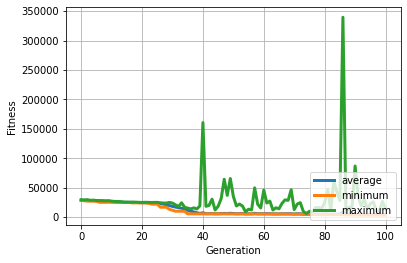

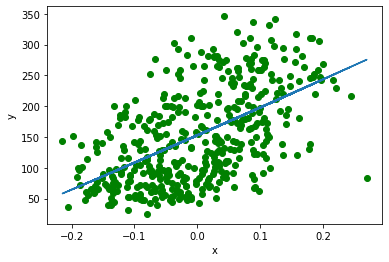

In [16]:
if __name__ == "__main__":
    pop, log, hof = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    
    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
    plt.plot(gen, avg, label="average", linewidth=3)
    plt.plot(gen, min_, label="minimum", linewidth=3)
    plt.plot(gen, max_, label="maximum", linewidth=3)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax.scatter(X, Y, color='g')
    
    Y_ = np.array([pred(hof[0], x) for x in X])
    ax.plot(X, Y_)

## Discussão sobre os resultados

Como resultado final temos o gráfico da regressão, podemos ver que nosso dataset chega no valor minimo esperado, sem muitas oscilações, também podemos ver que os valores de máximo, média e mínimo caminham juntos até a 20ª iteração, depois disso o valor de máxima acaba oscilando mais que os outros, fazendo o que ele demorasse mais para chegar no valor que desejado.
Como conclusão podemos tirar que a função usada funciona, sendo satisfatório o resultado a otimização, mesmo com o dataset demorando para regredir.
O melhor indivíduo da população na geração final representou uma curva similar a uma reta, com uma inclinação que procura ajustar os dados.
O Mean Squared Error do melhor indivíduo ainda é bastante alto, mas é de se esperar esse resultado ao observar os dados.

## Fontes


https://towardsdatascience.com/intro-to-evolutionary-computation-using-deap-618ca974b8cb

https://deap.readthedocs.io/en/master/

https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset